In [1]:
%pwd

'/home/minh/coding/dev/machinelearning/ShallowWaterJAX'

In [2]:
# %cd /work/gg0028/g260225/dev/diff-ocean-nemo
%cd '/home/minh/coding/dev/machinelearning/ShallowWaterJAX'


/home/minh/coding/dev/machinelearning/ShallowWaterJAX


In [4]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import utils.utilities as ut
from models import time_integration
from torch.utils.data import DataLoader
from dataset.dataset_nemo import preprocess_data
from models import networks as net
import xarray as xr
import hydra
from omegaconf import DictConfig, OmegaConf
import logging
import matplotlib.animation as animation
from src.nnUtils import autoregressive
import imageio
import io
import re
from models.emulator_module import EmulatorModule
log = logging.getLogger(__name__)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {DEVICE}")

import jax.numpy as jnp
from jax import grad, jit, vmap
import jax
from tqdm import tqdm


Running on: cpu


In [4]:

CONDI_NET           = False
# NETWORK             = "UNETSWEv4"
# FORWARD_MODEL       = "ForwardEulerConstraintBC"
NETWORK             = "UNET2D"
FORWARD_MODEL       = "ForwardEuler"
DT                  = 300
# EXP_NAME          = "unet_closedbc_swe_scaleddata_exp2"
EXP_NAME            = "unet_closedbc_swe_std_exp6"
TESTCASE            = "swe"
NORMALIZE           = True
# NORMALIZE_TYPE      = "scale"
NORMALIZE_TYPE      = "std"
# PATH_TO_FILE      = "/work/gg0028/g260225/dev/diff-ocean-nemo/data/swe/smalldataset_dt300.npz"
wkdir               = "/home/minh/coding/dev/machinelearning/diff-ocean-nemo"
PATH_TO_FILE        = f"{wkdir}/data/swe/swe_d15_1data_100x100_dt300.npz"
SAVE_FWD_DIR        = f"{wkdir}/saved/forward"
FWD_EXP_DIR         = f"{SAVE_FWD_DIR}/{EXP_NAME}"
pathfile            = f"{FWD_EXP_DIR}/model.pth.tar"
folder_saving = FWD_EXP_DIR
CONSTRAINT_BC       = True


network_params = {
    'name': 'UNET2D',
    'condi_net': False,
    'in_channels': [3, 2],
    'out_channels': [3],
    'features': [16, 32, 64, 128, 256],
    'kernel_size': 3,
    'stride': 1,
    'padding': 1,
    'norm_type': 'GroupNorm',
    'activation': 'SiLU',
    'num_layers': 5,
}

In [5]:
def plot_2D_field(x, cmap='viridis', title='x'):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    im = ax.imshow(x, cmap=cmap, origin='lower', aspect='auto')
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
    plt.show()

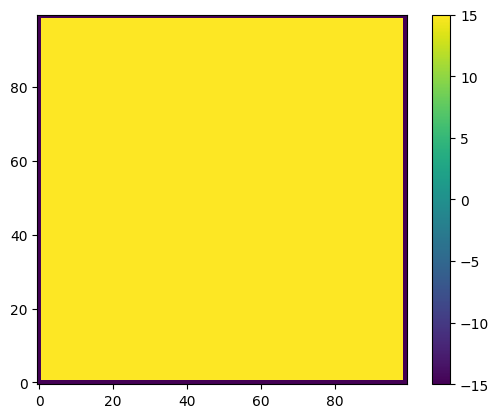

ssh.shape =  (1, 301, 100, 100)


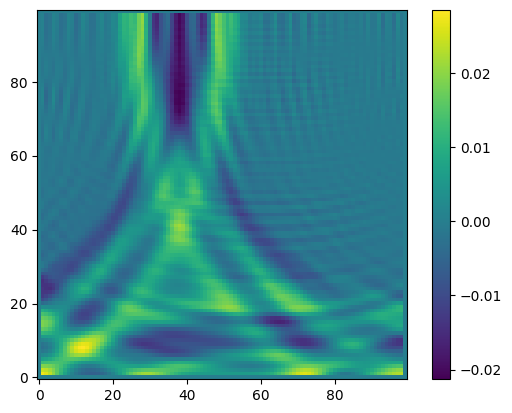

x0_mean:  5.4975302e-05
x0_std:  1.0005038
x1_mean:  -0.00013156311
x1_std:  1.0003442
x2_mean:  -0.0009699822
x2_std:  1.0001193
(1, 301, 3, 100, 100)
(300, 3, 100, 100)


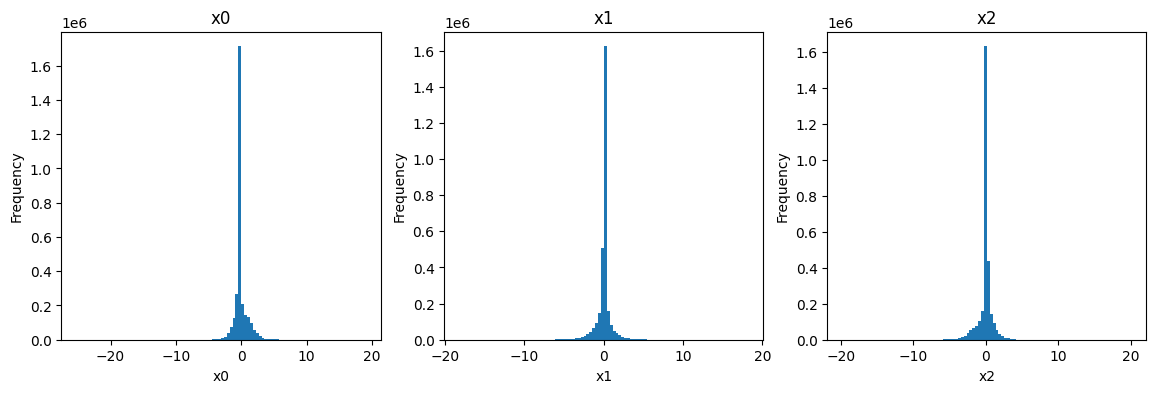

In [6]:
ocean_ds, ssh, params = preprocess_data(np.load(PATH_TO_FILE), TESTCASE, CONDI_NET, True, NORMALIZE_TYPE)
ut.plot_distribution_histogram(ocean_ds.X_input, 3)
print(ocean_ds.data.shape)
print(ocean_ds.X_input.shape)

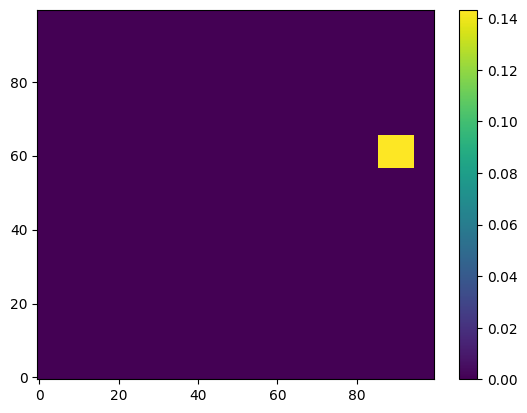

In [7]:
# plot 10 initial conditions
num_plot = ssh.shape[0]
for i in range(num_plot):
    plt.subplot(1, num_plot, i+1)
    plt.imshow(ssh[i, 0, :, :], origin="lower", aspect="auto")
    plt.colorbar()

In [8]:
# swe_dxdt = getattr(net, NETWORK)(condi_net=CONDI_NET)
swe_dxdt = getattr(net, NETWORK)(**network_params)
swe_dxdt = ut.load_model(swe_dxdt, pathfile).to(DEVICE)
forward_model = getattr(time_integration, FORWARD_MODEL)(swe_dxdt, dt=DT)
print(swe_dxdt)
print(forward_model)
emulator = EmulatorModule(
                problem_name=ocean_ds.problem,
                model=swe_dxdt,
                forward_model_name=forward_model, 
                dt=DT,
                data_module=ocean_ds,
                constraintBC=CONSTRAINT_BC
            )

DEVICE on Loading model:  cpu
+++++++++++++++++++ LOADING trained model ++++++++++++++++++++++++++
UNET2D(
  (dynamics): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (statics): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder): ModuleList(
    (0): DoubleConv2D(
      (conv): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(4, 16, eps=1e-05, affine=True)
        (2): SiLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(4, 16, eps=1e-05, affine=True)
        (5): SiLU(inplace=True)
      )
    )
    (1): DoubleConv2D(
      (conv): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (2): SiLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(8, 3

In [9]:
def autoregressive(solver, x0, params, H, mask, time_steps=10, folder_saving=None):
    Xs = []
    x = x0.clone()
    for t in range(time_steps):
        print(f"Rollout at time: {t}")
        Xs.append(x.detach().cpu().numpy())  # start with initial condition
        # x = solver.step(x, params=params, H=H, mask=mask)
        x = solver.forward(x, params=params, H=H, mask=mask)
    return np.concatenate(Xs, axis=0)
    # return torch.cat(Xs, axis=0)

## Simulation SWE with autoregressive

In [10]:
ocean_ds.H.shape

(300, 1, 100, 100)

In [11]:
ocean_ds.maskBC.shape

(300, 1, 100, 100)

torch.Size([1, 1, 100, 100])
torch.Size([1, 3, 100, 100])


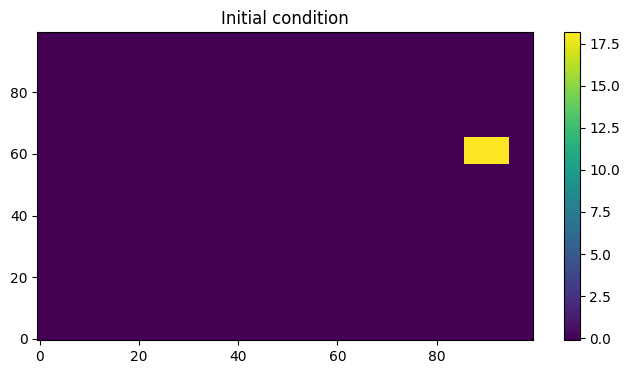

Rollout at time: 0
Rollout at time: 1
Rollout at time: 2
Rollout at time: 3
Rollout at time: 4
Rollout at time: 5
Rollout at time: 6
Rollout at time: 7
Rollout at time: 8
Rollout at time: 9
Rollout at time: 10
Rollout at time: 11
Rollout at time: 12
Rollout at time: 13
Rollout at time: 14
Rollout at time: 15
Rollout at time: 16
Rollout at time: 17
Rollout at time: 18
Rollout at time: 19
Rollout at time: 20
Rollout at time: 21
Rollout at time: 22
Rollout at time: 23
Rollout at time: 24
Rollout at time: 25
Rollout at time: 26
Rollout at time: 27
Rollout at time: 28
Rollout at time: 29
Rollout at time: 30
Rollout at time: 31
Rollout at time: 32
Rollout at time: 33
Rollout at time: 34
Rollout at time: 35
Rollout at time: 36
Rollout at time: 37
Rollout at time: 38
Rollout at time: 39
Rollout at time: 40
Rollout at time: 41
Rollout at time: 42
Rollout at time: 43
Rollout at time: 44
Rollout at time: 45
Rollout at time: 46
Rollout at time: 47
Rollout at time: 48
Rollout at time: 49
Rollout at

In [12]:
# simulation swe with autoregressive model for 10 time steps
H0 = torch.from_numpy(ocean_ds.H[0:1]).to(DEVICE)
print(H0.shape)
mask0 = torch.from_numpy(ocean_ds.maskBC[0:1]).to(DEVICE)
x0 = torch.from_numpy(ocean_ds.X_input[0:1]).to(DEVICE)
params0 = params[0:1, ...].to(DEVICE) if params is not None else None
print(x0.shape)
# plot x0 initial condition
plot_2D_field(x0[0, 0, :, :].detach().cpu().numpy(), title="Initial condition")
time_steps = 300
# emulator_sims = autoregressive(forward_model, x0, params0, H0, mask0, time_steps, folder_saving)
emulator_sims = autoregressive(emulator, x0, params0, H0, mask0, time_steps, folder_saving)

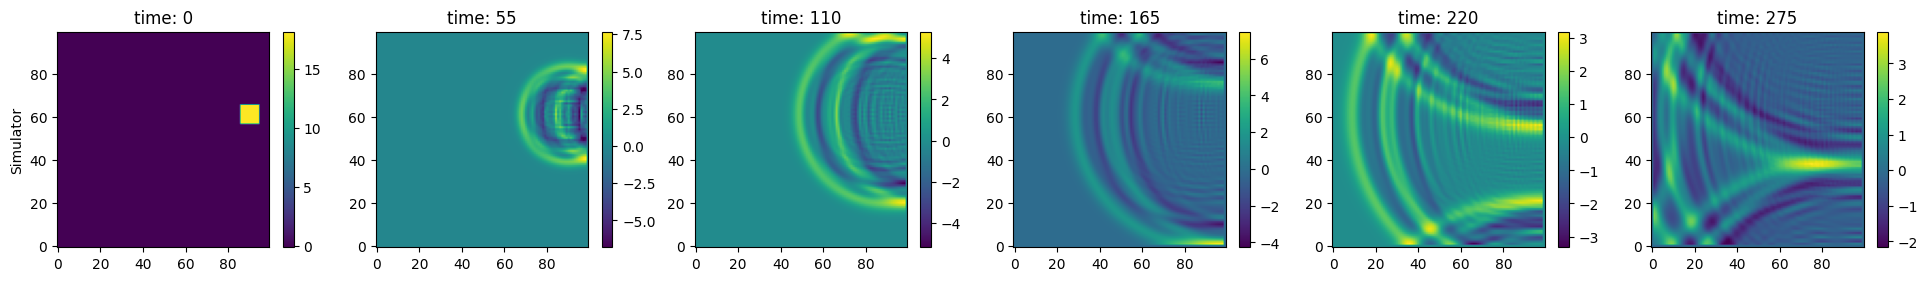

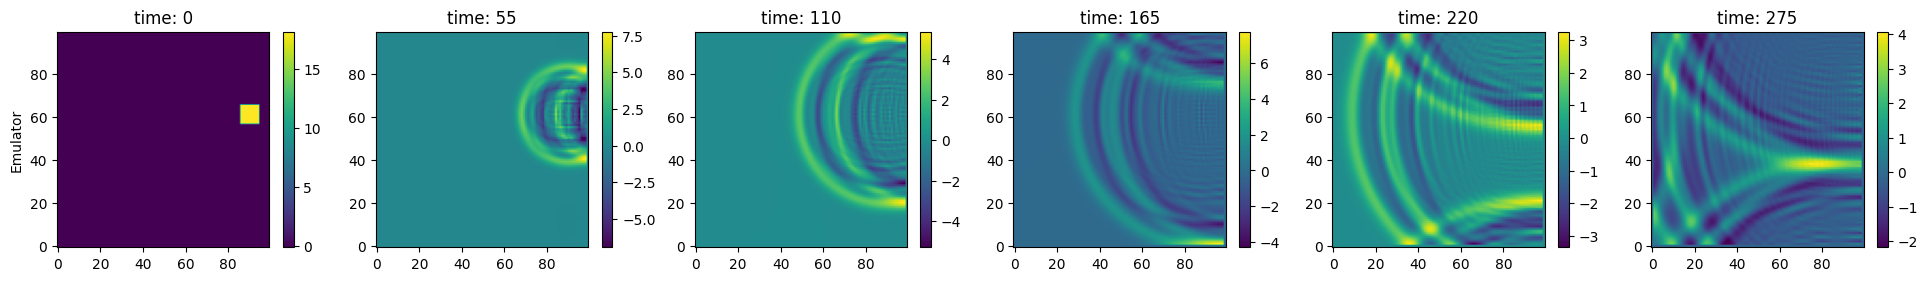

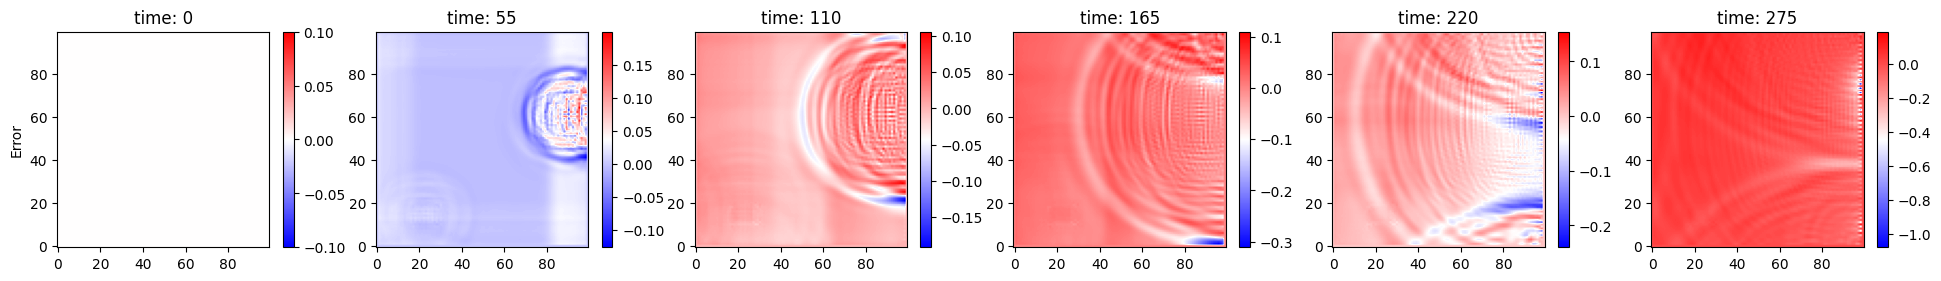

In [13]:
gt_sims = ocean_ds.X_input
# plot the simulation
num_subplot = 6
jump = 55
plt.figure(figsize=(num_subplot*4, 2.8))
for i in range(num_subplot):
    j = i * jump
    plt.subplot(1, num_subplot, i+1)
    plt.imshow(gt_sims[j, 0, :, :], origin="lower", aspect="auto")
    plt.title(f"time: {j}")
    plt.colorbar()
    if i == 0:
        plt.ylabel("Simulator")
plt.figure(figsize=(num_subplot*4, 2.8))
for i in range(num_subplot):
    j = i * jump
    plt.subplot(1, num_subplot, i+1)
    plt.imshow(emulator_sims[j, 0, :, :], origin="lower", aspect="auto")
    plt.title(f"time: {j}")
    plt.colorbar()
    if i == 0:
        plt.ylabel("Emulator")
plt.figure(figsize=(num_subplot*4, 2.8))
for i in range(num_subplot):
    j = i * jump
    plt.subplot(1, num_subplot, i+1)
    plt.imshow((gt_sims - emulator_sims)[j, 0, :, :], origin="lower", aspect="auto", cmap="bwr")
    plt.title(f"time: {j}")
    plt.colorbar()
    if i == 0:
        plt.ylabel("Error")
# fig, axs = plt.subplots(1, 5, figsize=(20, 2))
# for i in range(5):
#     j = i*70
#     axs[i].imshow(Xs[j, 0, :, :], origin="lower")
#     axs[i].axis("off")


## Observation 

In [14]:
Nx = ssh.shape[2]
Ny = ssh.shape[3]
Nt_steps = time_steps
t0 = 0
Nt_warmup = 10
t_warmup = Nt_warmup * DT
tmax = (Nt_steps - 1) * DT
print('Nx:', Nx)
print('Ny:', Ny)
print('t0:', t0)
print('t_warmup:', t_warmup)
print('tmax:', tmax)

Nx: 100
Ny: 100
t0: 0
t_warmup: 3000
tmax: 89700


In [15]:
# generate observations
print('generating observations.')
obs_frequency = 10 # every 10th time step
Nt_obs = int((tmax - t_warmup) / (obs_frequency * DT)) + 1
print(Nt_obs)
# obs_idx_t = [obs_frequency * i for i in range(Nt_obs)]  # oib
# print("len of obs_idx_t", len(obs_idx_t))
# print('obs_idx_t:', obs_idx_t)

generating observations.
29


In [16]:
idx_t = [i for i in range(Nt_steps)]
idx_t_warmup = [i for i in range(Nt_warmup)]
idx_t_after_warmup = [i for i in range(Nt_warmup, Nt_steps)]
idx_t_obs = [i for i in range(Nt_warmup, Nt_steps, obs_frequency)]
print('idx_t:', idx_t)
print('len(idx_t):', len(idx_t))
print('idx_t_init:', idx_t_warmup)
print('len(idx_t_init):', len(idx_t_warmup))
print('idx_t_after_warmup:', idx_t_after_warmup)
print('len(idx_t_after_warmup):', len(idx_t_after_warmup))
print('idx_t_obs:', idx_t_obs)
print('len(idx_t_obs):', len(idx_t_obs))
Nt_after_warmup = len(idx_t_after_warmup)
print('Nt_after_warmup:', Nt_after_warmup)


idx_t: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [17]:
t = [t0 + i * DT for i in range(Nt_steps)]
t_warmup = [t0 + i * DT for i in range(Nt_warmup)]
t_after_warmup = [t_warmup[-1] + i * DT for i in range(1, Nt_steps - Nt_warmup + 1)]
t_obs = t_after_warmup[::obs_frequency]

print('t:', t)
print('len(t):', len(t))
print('t_warmup:', t_warmup)
print('len(t_warmup))', len(t_warmup))
print('t_after_warmup:', t_after_warmup)
print('len(t_after_warmup))', len(t_after_warmup))
print('t_obs:', t_obs)
print('len(t_obs))', len(t_obs))

t: [0, 300, 600, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300, 3600, 3900, 4200, 4500, 4800, 5100, 5400, 5700, 6000, 6300, 6600, 6900, 7200, 7500, 7800, 8100, 8400, 8700, 9000, 9300, 9600, 9900, 10200, 10500, 10800, 11100, 11400, 11700, 12000, 12300, 12600, 12900, 13200, 13500, 13800, 14100, 14400, 14700, 15000, 15300, 15600, 15900, 16200, 16500, 16800, 17100, 17400, 17700, 18000, 18300, 18600, 18900, 19200, 19500, 19800, 20100, 20400, 20700, 21000, 21300, 21600, 21900, 22200, 22500, 22800, 23100, 23400, 23700, 24000, 24300, 24600, 24900, 25200, 25500, 25800, 26100, 26400, 26700, 27000, 27300, 27600, 27900, 28200, 28500, 28800, 29100, 29400, 29700, 30000, 30300, 30600, 30900, 31200, 31500, 31800, 32100, 32400, 32700, 33000, 33300, 33600, 33900, 34200, 34500, 34800, 35100, 35400, 35700, 36000, 36300, 36600, 36900, 37200, 37500, 37800, 38100, 38400, 38700, 39000, 39300, 39600, 39900, 40200, 40500, 40800, 41100, 41400, 41700, 42000, 42300, 42600, 42900, 43200, 43500, 43800, 44100, 

## Temporal observation

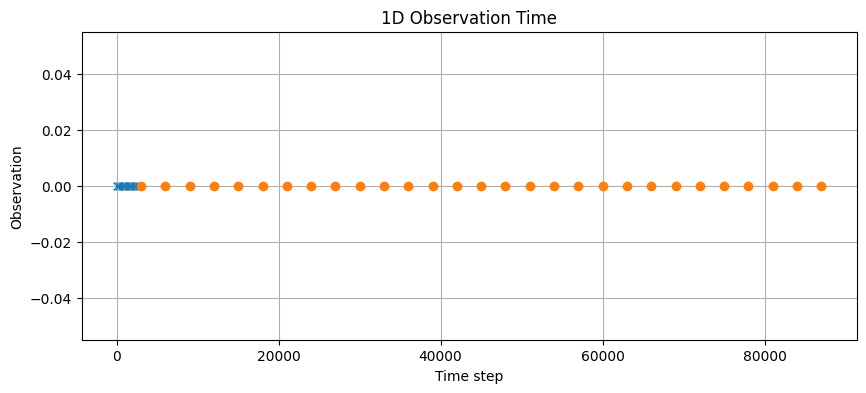

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(t_warmup, np.zeros_like(t_warmup), 'x')
plt.plot(t_obs, np.zeros_like(t_obs), 'o')
plt.xlabel('Time step')
plt.ylabel('Observation')
plt.title('1D Observation Time')
plt.grid(True)
plt.show()

In [19]:
gt_sims.shape

(300, 3, 100, 100)

## Generating the masks

In [20]:
import jax
import jax.numpy as jnp

def create_mask(ratio_obs, Nx, Ny, Nt_obs, key):
    mask = jnp.zeros((Nt_obs, 3, Nx, Ny))
    for i in range(Nt_obs):
        key, subkey = jax.random.split(key)
        mask = mask.at[i, 0, :, :].set(jax.random.choice(subkey, jnp.array([0, 1]), shape=(Nx, Ny), p=jnp.array([1-ratio_obs, ratio_obs])))
        key, subkey = jax.random.split(key)
        mask = mask.at[i, 1, :, :].set(jax.random.choice(subkey, jnp.array([0, 1]), shape=(Nx, Ny), p=jnp.array([1-ratio_obs, ratio_obs])))
        key, subkey = jax.random.split(key)
        mask = mask.at[i, 2, :, :].set(jax.random.choice(subkey, jnp.array([0, 1]), shape=(Nx, Ny), p=jnp.array([1-ratio_obs, ratio_obs])))
    return mask

key = jax.random.PRNGKey(0)
mask = create_mask(0.5, Nx, Ny, Nt_obs, key)
print(mask.shape)

(29, 3, 100, 100)


In [21]:
type(mask)

jaxlib.xla_extension.ArrayImpl

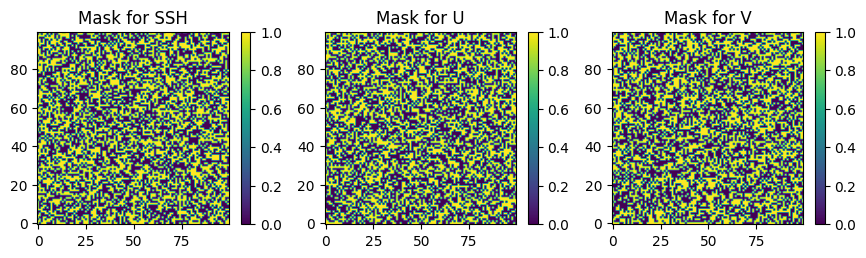

In [22]:

# plot the mask
plt.figure(figsize=(10.5, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(mask[0, 0, :, :], origin='lower', aspect='auto')
plt.colorbar()
plt.title('Mask for SSH')
plt.subplot(1, 3, 2)
plt.imshow(mask[0, 1, :, :], origin='lower', aspect='auto')
plt.colorbar()
plt.title('Mask for U')
plt.subplot(1, 3, 3)
plt.imshow(mask[0, 2, :, :], origin='lower', aspect='auto')
plt.colorbar()
plt.title('Mask for V')
plt.show()

## Apply the mask to the input data to create the pseduo observation

In [23]:
# create a jax x_obs based on numpy gt_sims
x_obs_jax = jnp.array(gt_sims[idx_t_obs])
print(x_obs_jax.shape)
print(type(x_obs_jax))

(29, 3, 100, 100)
<class 'jaxlib.xla_extension.ArrayImpl'>


In [24]:
mask.shape

(29, 3, 100, 100)

In [25]:
# apply the mask to the input data to create the observation
def apply_mask(data, mask):
    data_obs = data * mask
    return data_obs

# create the observation
y_obs_jax = apply_mask(x_obs_jax, mask)

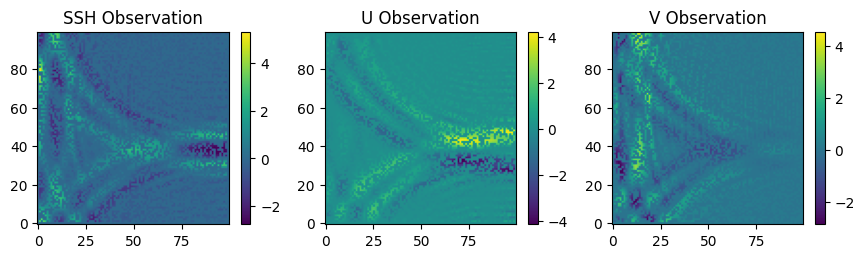

In [26]:
# plot the y_obs_jax
plt.figure(figsize=(10.5, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(y_obs_jax[-1, 0, :, :], origin='lower', aspect='auto')
plt.colorbar()
plt.title('SSH Observation')
plt.subplot(1, 3, 2)
plt.imshow(y_obs_jax[-1, 1, :, :], origin='lower', aspect='auto')
plt.colorbar()
plt.title('U Observation')
plt.subplot(1, 3, 3)
plt.imshow(y_obs_jax[-1, 2, :, :], origin='lower', aspect='auto')
plt.colorbar()
plt.title('V Observation')
plt.show()



(1, 3, 100, 100)
<class 'jaxlib.xla_extension.ArrayImpl'>


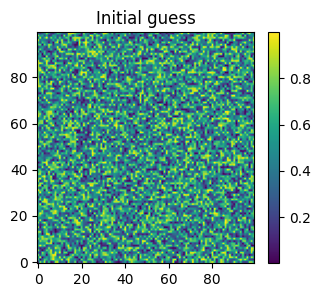

In [27]:
# create the initial guess 
key = jax.random.PRNGKey(1)
x0_jax = jax.random.uniform(key, (1, 3, Ny, Nx))
print(x0_jax.shape)
print(type(x0_jax))
# plot the initial guess
plt.figure(figsize=((3.5, 3)))
plt.subplot(1, 1, 1)
plt.imshow(x0_jax[0, 0, :, :], origin='lower', aspect='auto')
plt.colorbar()
plt.title('Initial guess')
plt.show()

# Coding 4DVar algorithm

In [28]:
import functools
import jax.numpy as jnp
import jax
import optax



''' 
Using `@functools.partial(jax.vmap, in_axes=(None, 0))` before the `network` function allows you to vectorize the function over the second argument (`x`) while keeping the first argument (`params`) fixed. This means that `network` will be applied to each element of the batch of inputs `x` independently, but with the same set of parameters `params`.

Here's a step-by-step explanation:

1. **Vectorization with `vmap`**: `jax.vmap` is a vectorization map that allows you to apply a function over a batch of inputs efficiently. It is similar to `numpy.vectorize` but optimized for JAX's automatic differentiation and hardware acceleration.

2. **Partial Application with `functools.partial`**: `functools.partial` is used to create a new function with some arguments fixed. In this case, it is used to fix the `in_axes` argument of `jax.vmap`.

3. **`in_axes` Argument**: The `in_axes` argument specifies how the inputs to the function should be batched. `in_axes=(None, 0)` means that the first argument (`params`) is not batched (i.e., it is the same for all elements in the batch), and the second argument (`x`) is batched along the first dimension (i.e., each row of `x` is treated as a separate input).

By using `@functools.partial(jax.vmap, in_axes=(None, 0))`, you are effectively creating a new function that applies `network` to each element of the batch of inputs `x` independently, while keeping `params` fixed.

Here is an example to illustrate this:
'''
# Define the network function
@functools.partial(jax.vmap, in_axes=(None, 0))
def network(paramsX, x):
    return jnp.dot(paramsX, x)

def compute_loss(paramsX, x, y):
    y_pred = network(paramsX, x)
    return jnp.mean(optax.l2_loss(y, y_pred))

target_params = 0.5
xs = jax.random.normal(jax.random.PRNGKey(0), (16, 2))
ys = jnp.sum(xs * target_params, axis=1)
optimizer = optax.adam(1e-1)
paramsX = jnp.array([0.0, 0.0])
opt_state = optimizer.init(paramsX)
for _ in range(1000):
    # print("xs = ", xs)
    # print("xs.shape", xs.shape)
    # print("ys = ", ys)
    # print("ys.shape", ys.shape)
    grads = jax.grad(compute_loss)(paramsX, xs, ys)
    updates, opt_state = optimizer.update(grads, opt_state)
    paramsX = optax.apply_updates(paramsX, updates)
print(paramsX)


[0.5 0.5]


In [29]:
from typing import Union, List
import torch

def run_simulation(initial_state, emulator, params, H_bathy, mask, further_step: Union[int, List[int]] = 1):
    assert isinstance(further_step, (int, list)), "further_step must be either an integer or a list"
    further_step = [further_step] if isinstance(further_step, int) else further_step
    emulator.model.eval()
    states = []
    state = initial_state.clone()       
    # for step in further_step:
    for i, step in enumerate(further_step):
        # print(f"Rollout step: {step}")
        if i == 0 and step == 0:
            states.append(state)
            continue
        # Simplify the loop by directly using the last state if available
        if i == 0 and step > 0:
            for _ in range(step):
                state = emulator.forward(state, params=params, H=H_bathy, mask=mask)
            states.append(state)
        elif i > 0:
            for j, val in enumerate(range(further_step[i]-further_step[i-1])):
                state = emulator.forward(state, params=params, H=H_bathy, mask=mask)
            states.append(state)
    print("len(states): ", len(states))
    return torch.cat(states, dim=0)

In [30]:
idx_t_obs

[10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290]

len(states):  29
(29, 3, 100, 100)


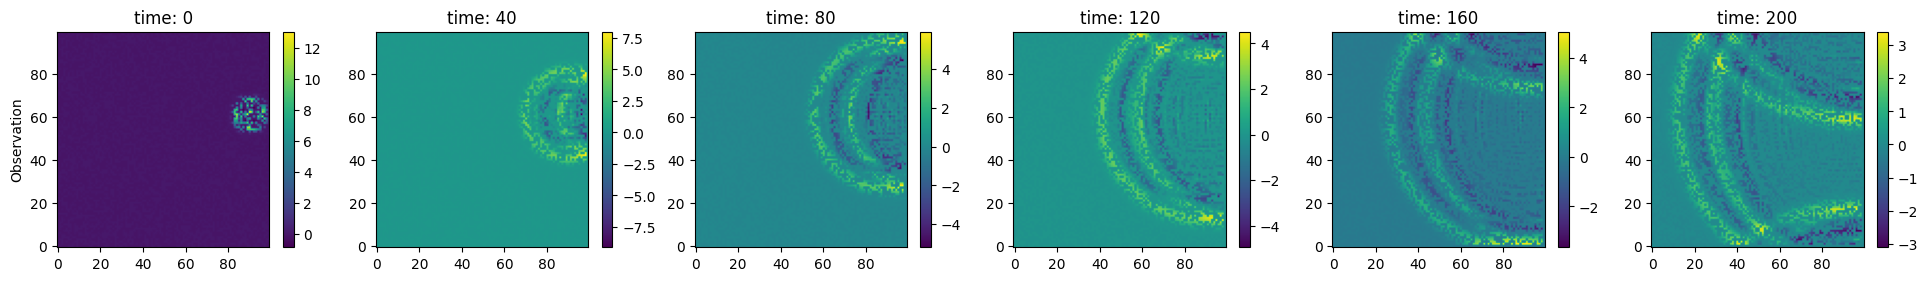

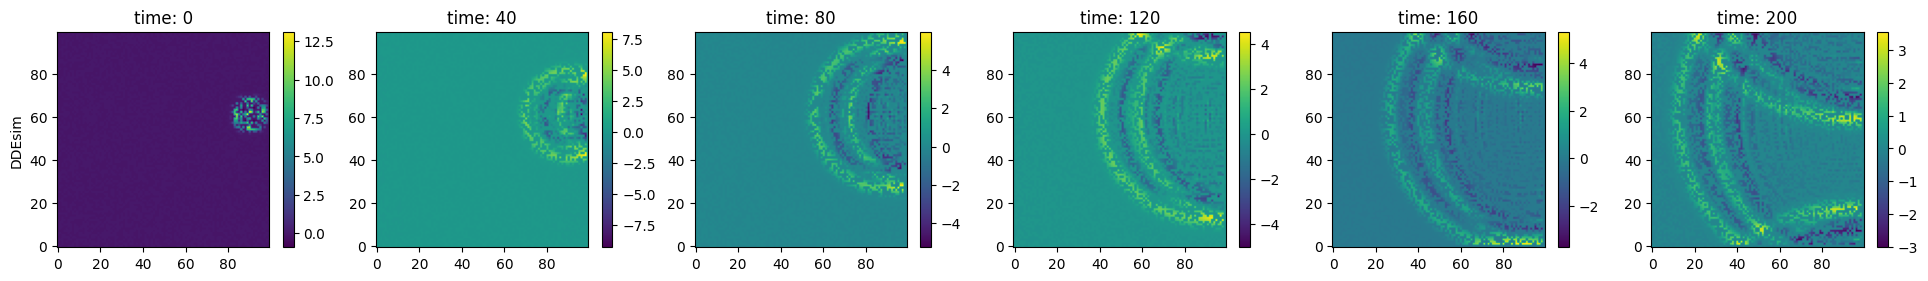

In [31]:
# test run_simulation
x0 = torch.from_numpy(ocean_ds.X_input[0:1]).to(DEVICE)
H0 = torch.from_numpy(ocean_ds.H[0:1]).to(DEVICE)
mask0 = torch.from_numpy(ocean_ds.maskBC[0:1]).to(DEVICE)
params0 = params[0:1, ...].to(DEVICE) if params is not None else None
simulations = run_simulation(x0, emulator, params0, H0, mask0, idx_t_obs)
# convert torch tensor simulations to jax array
simulations = jnp.array(simulations.detach().cpu().numpy())
print(simulations.shape)
# plot the comparison between the simulation and the ground truth
# plot the simulations
# plt.figure(figsize=(3.5, 2.5))
# plt.subplot(1, 1, 1)
# plt.imshow(simulations[-1, 0, :, :].detach().cpu().numpy(), origin='lower', aspect='auto')
# plt.colorbar()
# plt.title('SSH Simulation')
# plt.show()
num_subplot = 6
jump = 4
plt.figure(figsize=(num_subplot*4, 2.8))
for i in range(num_subplot):
    j = i * jump
    plt.subplot(1, num_subplot, i+1)
    plt.imshow(apply_mask(x_obs_jax, mask)[j, 0, :, :], origin="lower", aspect="auto")
    plt.title(f"time: {j * obs_frequency}")
    plt.colorbar()
    if i == 0:
        plt.ylabel("Observation")
plt.figure(figsize=(num_subplot*4, 2.8))
for i in range(num_subplot):
    j = i * jump
    plt.subplot(1, num_subplot, i+1)
    plt.imshow(apply_mask(simulations, mask)[j, 0, :, :], origin="lower", aspect="auto")
    plt.title(f"time: {j * obs_frequency}")
    plt.colorbar()
    if i == 0:
        plt.ylabel("DDEsim")
# plt.figure(figsize=(num_subplot*4, 2.8))
# for i in range(num_subplot):
#     j = i * jump
#     plt.subplot(1, num_subplot, i+1)
#     plt.imshow((x_obs_jax - simulations)[j, 0, :, :], origin="lower", aspect="auto", cmap="bwr")
#     plt.title(f"time: {j}")
#     plt.colorbar()
#     if i == 0:
#         plt.ylabel("Error")
plt.show()

In [ ]:
# write a jax function that mimics the run_simulation function receiving the initial state, emulator, params, H_bathy, mask, further_step and producing the simulations
def run_simulation_jax(initial_state, emulator, params, H_bathy, mask, further_step: Union[int, List[int]] = 1):
    assert isinstance(further_step, (int, list)), "further_step must be either an integer or a list"
    further_step = [further_step] if isinstance(further_step, int) else further_step
    # emulator.model.eval()
    states = []
    state = initial_state
    for i, step in enumerate(further_step):
        if i == 0 and step == 0:
            states.append(state)
            continue
        # Simplify the loop by directly using the last state if available
        if i == 0 and step > 0:
            for _ in range(step):
                # state = emulator.forward(state, params=params, H=H_bathy, mask=mask)
                state = emulator(state, params, H_bathy, mask)
                state = state.reshape(1, 3, 100, 100)
            states.append(state)
        elif i > 0:
            for j, val in enumerate(range(further_step[i]-further_step[i-1])):
                # state = emulator.forward(state, params=params, H=H_bathy, mask=mask)
                state = emulator(state, params, H_bathy, mask)
                state = state.reshape(1, 3, 100, 100)
            states.append(state)
    return jnp.stack(states, 0).squeeze(1)

In [79]:
# @functools.partial(jax.vmap, in_axes=(None, 0))
# define the cost function using @functools where we keep the mask in constant, x and y_obs are the variables
import functools
from jax import jit
# @functools.partial(jax.vmap, in_axes=(0, 1, None))
# @functools.partial(jax.vmap, in_axes=(0, 0, 0))
# @jit
# @functools.partial(jax.vmap, in_axes=(0, None, None, None, None, None, None, None))

def cost_function(x0, y_obs, mask, emulator, params0, H0, mask0, idx_t_obs):
    x = run_simulation_jax(x0, emulator, params0, H0, mask0, idx_t_obs)
    x_obs = apply_mask(x, mask)
    # compute the rmse
    rmse = jnp.sqrt(jnp.mean((x_obs - y_obs)**2))
    return rmse

In [80]:
# write a jax network model that takes in params and x as input and return the output
@functools.partial(jax.vmap, in_axes=(None, 0, 0, 0))
def UNET2D(x0, params, H, mask):
    # generate random key
    key = jax.random.PRNGKey(0)
    # generate the 29 simulations based on the initial condition
    dx_dt = jax.random.normal(key, (1, 3, 100, 100))
    dT = 300
    x_next = jnp.add(jnp.multiply(dx_dt, dT), x0)
    return x_next


In [81]:
import optax
import numpy as onp

def run_4DVar(x0, y_obs, emulator, params0, H0, mask0, idx_t_obs, N_iter, lr=0.1):
    optimizer = optax.adam(lr)
    optimizer_state = optimizer.init(x0)
    for i in range(N_iter):
        print("iter: ", i)
        # # convert x0 from jax array to pytorch tensor
        # x0_numpy = onp.array(x0)
        # x0_torch = torch.from_numpy(x0_numpy).to(torch.float32)
        # x = run_simulation_jax(x0, emulator, params0, H0, mask0, idx_t_obs) # run the simulation using the emulator written in Pytorch
        # x_jax = jnp.array(simulations.detach().cpu().numpy()) # convert the simulation to jax array
        grads = jax.grad(cost_function)(x0, y_obs, mask, emulator, params0, H0, mask0, idx_t_obs)
        print("loss: ", cost_function(x0, y_obs, mask, emulator, params0, H0, mask0, idx_t_obs))
        updates, optimizer_state = optimizer.update(grads, optimizer_state)
        x0 = optax.apply_updates(x0, updates)
    return x0

In [82]:
final_x0 = run_4DVar(x0_jax, y_obs_jax, UNET2D, params0, H0, mask0, idx_t_obs, 100, 0.1)

iter:  0


TypeError: Gradient only defined for scalar-output functions. Output had shape: (1,).

In [81]:
# pytorch code of 4DVar
def run_data_assimilation(self, datatest_loader):
        # Using tensorboard
        self.writer = self.set_summary_writer()
        # freeze the model
        self.freeze_model(self.emulator)
        # set the initial state and physical parameters
        self.set_initState_and_physParams()
        # set the optimizer
        self.initialize_optimizer()
        # set the scheduler
        optimizer = self.optimizers["adam"]
        for iter in tqdm(range(self.switch_to_lbfgs_after)):
            # Use Adam for the initial phase
            # optimizer = self.optimizers["adam"]
            optimizer.zero_grad()
            simulations = self.rollout(self.emulator, self.initial_state, self.physical_params, self.other_params, further_step=self.dt_list)
            loss = self.observations_operator.mseloss(simulations, self.observations, self.dt_list)
            loss.backward()
            optimizer.step()
            self.scheduler_adam.step() # Update the scheduler
            self._update_writer(loss, iter, opt='adam')
        # Switch to LBFGS for fine-tuning
        optimizer = self.optimizers["lbfgs"]
        # loss = 0
        iter = [self.switch_to_lbfgs_after]

        class OptimizationStop(Exception):
            pass

        def closure():
            optimizer.zero_grad()
            simulations = self.rollout(self.emulator, self.initial_state, self.physical_params, self.other_params, further_step=self.dt_list)
            # ut.plot_x_2d(self.observations[0,0,...], 'observed')
            loss = self.observations_operator.mseloss(simulations, self.observations, self.dt_list)            
            # print(f"Loss at LBFGS sub-step {step}: {loss.item()}")
            loss.backward()
            self._update_writer(loss, iter[0], opt='lbfgs')
            iter[0] += 1
            if self._check_criteria(loss):
                # print("Loss is less than 1e-10, stopping early.")
                # GO OUT OF THE CLOSURE
                raise OptimizationStop("Loss criterion reached. Stopping LBFGS optimization.")
            return loss
        try:
            optimizer.step(closure=closure)
        except OptimizationStop as e:
            print(e)

        self.writer.flush()
        self.writer.close()
        ut.save_values_with_arrays(f"{self.ckp_path}/x0_params.pkl", self.results)
        return self.initial_state, self.physical_params, self.loss